# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import math

import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import pandas as pd
import dask
from tqdm import tqdm

import vector
import particle
import hepunits

import comet_ml
import zuko
import torch
from torch import nn, optim
import lightning as L
from lightning.pytorch import loggers as pl_loggers
from torch.utils.data import DataLoader, Subset

import multiprocessing
import uuid

from memflow.dataset.data import ParquetData
from memflow.dataset.dataset import CombinedDataset
from memflow.ttH.ttH_dataclasses import ttHHardDataset, ttHRecoDataset

from memflow.ttH.models.TransferCFM import StandardCFM as TransferCFM
from memflow.ttH.models.Transfusion import StandardCFM as Transfusion
from memflow.ttH.models.ParallelTransfusion import StandardCFM as ParallelTransfusion
from memflow.ttH.models.TransferCFM_original import StandardCFM as OriginalCFM

from memflow.ttH.distribution_plots import *
from models.utils import load_samples, save_samples
from models.callbacks import SamplingCallback, BiasCallback, MultiModelHistogramPlotter

from transfer_flow.transfer_flow_model import *
from transfer_flow.custom_flows import *

vector.register_awkward()

num_workers = min(16, multiprocessing.cpu_count())  # Use up to 16 CPU cores
print(f'Number of CPU workers for dataloading: {num_workers}')
os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # Change "<n>" to the index of the GPU you want to use on node

print (f"Running on GPU : {torch.cuda.is_available()}")
accelerator = 'cuda' if torch.cuda.is_available() else 'cpu'
print (f"Accelerator : {accelerator}")
torch.set_float32_matmul_precision('medium')
if accelerator =='cuda':
    torch.cuda.empty_cache()
    print (torch.cuda.memory_summary(device=None, abbreviated=True))

/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
2025-03-15 12:03:22.250090: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-15 12:03:22.250146: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-15 12:03:22.250155: E tensorflow/c

Number of CPU workers for dataloading: 16
Running on GPU : True
Accelerator : cuda
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Requested memory      |      0 B   |      0 B   |      0 

# Data

In [2]:
data_hard = ParquetData(
    files = [
        '/cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/hard/2018/ttH/ttH_HToInvisible_M125.parquet',
        #'all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1_validation.parquet',
        #'all_jets_fullRun2_ttHTobb_forTraining_2016_PreVFP_v3.parquet',
    ],
    lazy = True,
    # N = int(1e5),
)

print (data_hard)

Data object
Loaded branches:
   ... file: 1903554
   ... sample: 1903554
   ... tree: 1903554
Branch in files not loaded:
   ... Generator_scalePDF
   ... Generator_weight
   ... Generator_x1
   ... Generator_x2
   ... Generator_xpdf1
   ... Generator_xpdf2
   ... W_minus_from_antitop_eta
   ... W_minus_from_antitop_genPartIdxMother
   ... W_minus_from_antitop_idx
   ... W_minus_from_antitop_mass
   ... W_minus_from_antitop_pdgId
   ... W_minus_from_antitop_phi
   ... W_minus_from_antitop_pt
   ... W_minus_from_antitop_status
   ... W_minus_from_antitop_statusFlags
   ... W_plus_from_top_eta
   ... W_plus_from_top_genPartIdxMother
   ... W_plus_from_top_idx
   ... W_plus_from_top_mass
   ... W_plus_from_top_pdgId
   ... W_plus_from_top_phi
   ... W_plus_from_top_pt
   ... W_plus_from_top_status
   ... W_plus_from_top_statusFlags
   ... Z_from_higgs_eta
   ... Z_from_higgs_genPartIdxMother
   ... Z_from_higgs_idx
   ... Z_from_higgs_mass
   ... Z_from_higgs_pdgId
   ... Z_from_higgs_phi

# Hard dataset

In [3]:
hard_dataset = ttHHardDataset(
    data = data_hard,
    selection = [
        # 'higgs',
        # 'tops',
        'bottoms',
        # 'Ws',
        # 'Zs',
        'quarks',
        'neutrinos',
    ],
    build = False,
    fit = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)

print(hard_dataset)

Loading objects from /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard
Saving preprocessing to /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard
Will overwrite what is in output directory /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard/preprocessing
Preprocessing saved in /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard/preprocessing
Parton dataset with 756642 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [25, 6, -6]
 Final states masses   : [125.2, 172.57, 172.57]
Containing the following tensors
bottoms    : data ([756642, 2, 5]), mask ([756642, 2])
             Mask exist    : [100.00%, 100.00%]
             Mask attn     : [True, True]
             Weights       : 756642.00, 756642.00
             Features      : ['pt', 'eta', 'phi', 'mass', 'pdgId']
             Selected for batches : True
Zs         : data ([756642, 2, 5]), mask ([756642, 2])
             Mask exist    : [100.00%, 100.00%]
             Mask attn  

# Reco dataset

In [4]:
data_reco = ParquetData(
    files = [
        '/cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/reco/2018/ttH/ttH_HToInvisible_M125.parquet',
    ],
    lazy = True,
    #N = data_hard.N,
)

print(data_reco)

Data object
Loaded branches:
   ... file: 231528
   ... sample: 231528
   ... tree: 231528
Branch in files not loaded:
   ... Generator_scalePDF
   ... Generator_weight
   ... Generator_x1
   ... Generator_x2
   ... Generator_xpdf1
   ... Generator_xpdf2
   ... InputMet_phi
   ... InputMet_pt
   ... cleanedJet_btagDeepFlavB
   ... cleanedJet_eta
   ... cleanedJet_mass
   ... cleanedJet_phi
   ... cleanedJet_pt
   ... event
   ... ncleanedBJet
   ... ncleanedJet
   ... region
   ... weight_nominal
   ... xs_weight


Have a look at athe minimum values for Jet and MET pT in the raw dataset. This can give an indication as to what the cutoff in the SR is and hence what to set the `'pt':lowercutshift()` to in the pre-processing

In [5]:
reco_dataset = ttHRecoDataset(
    data = data_reco,
    selection = [
        'jets',
        'met',
    ],
    build = False,
    fit = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)
print(reco_dataset)

Loading objects from /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco
Saving preprocessing to /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco
Will overwrite what is in output directory /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco/preprocessing
Preprocessing saved in /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco/preprocessing
Reco dataset with 114647 events
Containing the following tensors
jets  : data ([114647, 6, 5]), mask ([114647, 6])
        Mask exist    : [100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 62.85%]
        Mask attn     : [True, True, True, True, True, True]
        Weights       : 114647.00, 114647.00, 114647.00, 114647.00, 114647.00, 114647.00
        Features      : ['pt', 'eta', 'phi', 'mass', 'btag']
        Selected for batches : True
met   : data ([114647, 1, 4]), mask ([114647, 1])
        Mask exist    : [100.00%]
        Mask attn     : [True]
        Weights       : 114647.00
        Features      : ['pt

# Combined dataset

In [6]:
combined_dataset = CombinedDataset(
    hard_dataset=hard_dataset,
    reco_dataset=reco_dataset,
)

train_frac = 0.8
indices = torch.arange(len(combined_dataset))
sep = int(train_frac*len(combined_dataset))
valid_indices = indices[sep:]
combined_dataset_valid = torch.utils.data.Subset(combined_dataset,valid_indices)
print (f'Dataset : validation {len(combined_dataset_valid)}')


Intersection branches : `event` for hard dataset and `event` for reco dataset
Looking into file metadata
Will pair these files together :
   - /cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/hard/2018/ttH/ttH_HToInvisible_M125.parquet <-> /cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/reco/2018/ttH/ttH_HToInvisible_M125.parquet
For entry 0 : from 756642 events, 91819 selected
For entry 1 : from 114647 events, 91819 selected
Dataset : validation 18364


In [7]:
TransferCFM_model = TransferCFM.load_from_checkpoint(checkpoint_path="trained_model_checkpoints/TransferCFM_checkpoints/model_epoch_500.ckpt")
TransferCFM_model.to(accelerator)
TransferCFM_model.eval()

No hard attention mask provided; will use existence mask only.


/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.activation_relu_or_gelu was not True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


StandardCFM(
  (hard_embeddings): ModuleList(
    (0-2): 3 x Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=6, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (reco_embeddings): ModuleList(
    (0): Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=6, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
    (1): Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=5, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_fea

In [8]:
ParallelTransfusion_model = ParallelTransfusion.load_from_checkpoint(checkpoint_path="trained_model_checkpoints/parallel_transfusion_checkpoints/model_epoch_500.ckpt")
ParallelTransfusion_model.to(accelerator)
ParallelTransfusion_model.eval()

No hard attention mask provided; will use existence mask only.
Transformer args: will override `d_model` to 64
('pt', 'eta', 'phi', 'mass')
('pt', 'phi')


StandardCFM(
  (hard_embeddings): ModuleList(
    (0-2): 3 x Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=6, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (reco_embeddings): ModuleList(
    (0): Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=6, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
    (1): Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=5, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj)

In [9]:
transfermer_model = TransferFlow.load_from_checkpoint(
    checkpoint_path="trained_model_checkpoints/TransferFlow_checkpoints/model_epoch_500.ckpt",
    encoder_embeddings=MultiEmbeddings(
        features_per_type=combined_dataset.hard_dataset.input_features,
        embed_dims=[32, 64],
        hidden_activation=nn.GELU,
    ),
    decoder_embeddings=MultiEmbeddings(
        features_per_type=combined_dataset.reco_dataset.input_features,
        embed_dims=[32, 64],
        hidden_activation=nn.GELU,
    ),
    transformer=Transformer(
        d_model=64,
        encoder_layers=6,
        decoder_layers=8,
        nhead=8,
        dim_feedforward=256,
        activation=nn.GELU,
        encoder_mask_attn=None,
        decoder_mask_attn=combined_dataset.reco_dataset.attention_mask,
        use_null_token=True,
        dropout=0.0,
    ),
    flow=KinematicFlow(
        d_model=64,
        flow_mode='global',
        flow_features=[
            ['pt', 'eta', 'phi', 'mass'],  # jets
            ['pt', 'phi'],  # met
        ],
        flow_classes={
            'pt': zuko.flows.NSF,
            'eta': UniformNSF,
            'phi': UniformNCSF,
            'mass': zuko.flows.NSF,
        },
        flow_common_args={
            'bins': 16,
            'transforms': 5,
            'randperm': True,
            'passes': None,
            'hidden_features': [256] * 3,
        },
        flow_specific_args={
            'eta': {'bound': 1.0},
            'phi': {'bound': math.pi},
        },
    ),
)
transfermer_model.to(accelerator)
transfermer_model.eval()

/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder_embeddings' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_embeddings'])`.
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'decoder_embeddings' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['decoder_embeddings'])`.
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'transformer' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['transformer'])`.
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10

TransferFlow(
  (encoder_embeddings): MultiEmbeddings(
    (embeddings): ModuleList(
      (0-2): 3 x MLP(
        (layers): Sequential(
          (0): Linear(in_features=5, out_features=32, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=32, out_features=64, bias=True)
        )
      )
    )
  )
  (decoder_embeddings): MultiEmbeddings(
    (embeddings): ModuleList(
      (0): MLP(
        (layers): Sequential(
          (0): Linear(in_features=5, out_features=32, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=32, out_features=64, bias=True)
        )
      )
      (1): MLP(
        (layers): Sequential(
          (0): Linear(in_features=4, out_features=32, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=32, out_features=64, bias=True)
        )
      )
    )
  )
  (transformer): Transformer(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layer

In [13]:
sampling = SamplingCallback(
    dataset = combined_dataset_valid,           # dataset to check sampling
    preprocessing = combined_dataset.reco_dataset.preprocessing, # preprocessing pipeline
    idx_to_monitor = [1,2,3,4,5,6,7,8,9,10],               # idx of events in dataset to make plots with
    N_sample = 10000,                          # number of samples to draw
    steps = 20,                                     # Number of bridging steps
    store_trajectories = False,                     # To save trajectories plots
    frequency = 50,                             # plotting frequency (epochs)
    bins = 31,                                  # 1D/2D plot number of bins
    log_scale = True,                           # log scale
    label_names = {                             # makes nicer labels
        'pt' : r'$p_T$ [GeV]',
        'eta' : r'$\eta$',
        'phi' : r'$\phi$ [rad]',
        'mass': 'Mass [GeV]'
    },
    pt_range = 350,
)

bias = BiasCallback(
    dataset = combined_dataset_valid,               # dataset on which to evaluate bias
    preprocessing = combined_dataset.reco_dataset.preprocessing, # preprocessing pipeline to draw raw variables
    N_sample = 100,                                 # number of samples to draw
    steps = 20,                                     # Number of bridging steps
    store_trajectories = False,                     # To save trajectories plots
    frequency = 50,                                 # plotting frequency (epochs)
    bins = 101,                                      # 1D/2D plot number of bins
    points = 20,                                    # Number of points for the quantile
    log_scale = False,                               # log scale for the 1D histogram
    batch_size = 100,                              # Batch size to evaluate the dataset (internally makes a loaded)
    #N_batch = 20,                                   # Stop after N batches (makes it faster)
    suffix = 'ttH',                                 # name for plots
    label_names = {                             # makes nicer labels
        'pt' : 'p_T',
        'eta' : '\eta',
        'phi' : '\phi',
    },
)

# Transfermer per event sampling

In [11]:
transfermer_samples_file = "Transfermer_samples2.pt"

if os.path.exists(os.path.join("saved_samples", transfermer_samples_file)):
    transfermer_samples = load_samples(transfermer_samples_file)
else:
    device = transfermer_model.device
    sampling.set_idx(sampling.idx_to_monitor)

    # Move input data to the correct device
    hard_data = [d.to(device) for d in sampling.batch['hard']['data']]
    hard_mask = [m.to(device) for m in sampling.batch['hard']['mask']]
    reco_data = [d.to(device) for d in sampling.batch['reco']['data']]
    reco_mask = [m.to(device) for m in sampling.batch['reco']['mask']]

    print(f"Hard data batch size: {hard_data[0].shape[0]}")
    print(f"Reco data batch size: {reco_data[0].shape[0]}")

    # Number of samples per event
    total_samples = sampling.N_sample  
    batch_size = 10  # Number of samples per batch to avoid memory issues
    num_batches = (total_samples + batch_size - 1) // batch_size  # Ensure full coverage

    # Storage for results
    accumulated_samples = [None, None]  

    with torch.no_grad():
        for batch_idx in tqdm(range(num_batches), desc="Sampling batches", unit="batch"):
            # Determine the number of samples to generate in this batch
            current_N = min(batch_size, total_samples - batch_idx * batch_size)

            # Generate samples
            batch_samples = transfermer_model.sample(
                hard_data,
                hard_mask,
                reco_data,
                reco_mask,
                N=current_N
            )

            # Feature selection
            jets_indices = [0, 1, 2, 3]  # ['pt', 'eta', 'phi', 'mass']
            met_indices = [0, 2]         # ['pt', 'phi']

            batch_samples[0] = batch_samples[0][..., jets_indices]  # Filter jet features
            batch_samples[1] = batch_samples[1][..., met_indices]   # Filter MET features

            # Accumulate results
            if accumulated_samples[0] is None:
                accumulated_samples[0] = batch_samples[0].cpu()
                accumulated_samples[1] = batch_samples[1].cpu()
            else:
                accumulated_samples[0] = torch.cat((accumulated_samples[0], batch_samples[0].cpu()), dim=0)
                accumulated_samples[1] = torch.cat((accumulated_samples[1], batch_samples[1].cpu()), dim=0)

    # Convert final results to the expected format
    transfermer_samples = accumulated_samples

    # Debugging prints
    num_items = len(transfermer_samples)
    print(f"Number of elements per sample: {num_items}")
    for i, sample in enumerate(transfermer_samples):
        print(f"Sample {i}: {sample.shape}")

    # Save the concatenated samples
    save_samples(transfermer_samples, transfermer_samples_file)

# 3mins 27s, 10 events, 10000 samples


Samples loaded from saved_samples/Transfermer_samples2.pt


In [30]:
figures = sampling.make_sampling_plots(ParallelTransfusion_model,external_samples=transfermer_samples, cmap='RdPu', save_dir='sampling_plots/transfermer')

Saved: sampling_plots/transfermer/event_0_obj_jets_0.png
Saved: sampling_plots/transfermer/event_0_obj_jets_1.png
Saved: sampling_plots/transfermer/event_0_obj_jets_2.png
Saved: sampling_plots/transfermer/event_0_obj_jets_3.png
Saved: sampling_plots/transfermer/event_0_obj_jets_4.png
Saved: sampling_plots/transfermer/event_0_obj_jets_5.png
Saved: sampling_plots/transfermer/event_0_obj_met_0.png
Saved: sampling_plots/transfermer/event_1_obj_jets_0.png
Saved: sampling_plots/transfermer/event_1_obj_jets_1.png
Saved: sampling_plots/transfermer/event_1_obj_jets_2.png
Saved: sampling_plots/transfermer/event_1_obj_jets_3.png
Saved: sampling_plots/transfermer/event_1_obj_jets_4.png
Saved: sampling_plots/transfermer/event_1_obj_jets_5.png
Saved: sampling_plots/transfermer/event_1_obj_met_0.png
Saved: sampling_plots/transfermer/event_2_obj_jets_0.png
Saved: sampling_plots/transfermer/event_2_obj_jets_1.png
Saved: sampling_plots/transfermer/event_2_obj_jets_2.png
Saved: sampling_plots/transfermer

# Parallel Transfusion per event sampling

In [31]:
PT_samples_file = "PT_samples2.pt"
if os.path.exists(os.path.join("saved_samples", PT_samples_file)):
    PT_samples = load_samples(PT_samples_file)
else:
    device = ParallelTransfusion_model.device
    sampling.set_idx(sampling.idx_to_monitor)
    hard_data = [d.to(device) for d in sampling.batch['hard']['data']]
    hard_mask = [m.to(device) for m in sampling.batch['hard']['mask']]
    reco_data = [d.to(device) for d in sampling.batch['reco']['data']]
    reco_mask = [m.to(device) for m in sampling.batch['reco']['mask']]

    print(f"Hard data batch size: {hard_data[0].shape[0]}")
    print(f"Reco data batch size: {reco_data[0].shape[0]}")

    with torch.no_grad():
        model = ParallelTransfusion_model.to(ParallelTransfusion_model.device)
        PT_samples = model.sample(
                            hard_data, hard_mask,
                            reco_data, reco_mask,
                            sampling.N_sample,
                            sampling.steps,
                            sampling.store_trajectories
                        )
    # Debugging prints
    num_items = len(PT_samples)
    print(f"Number of elements per sample: {num_items}")
    for i, sample in enumerate(PT_samples):
        print(f"Sample {i}: {sample.shape}")
    save_samples(PT_samples, PT_samples_file)

# 42mins 14s for 10 events, 10000 samples

Samples loaded from saved_samples/PT_samples2.pt


In [32]:
figures = sampling.make_sampling_plots(ParallelTransfusion_model,external_samples=PT_samples, cmap='BuGn', save_dir='sampling_plots/parallel_transfusion')

Saved: sampling_plots/parallel_transfusion/event_0_obj_jets_0.png
Saved: sampling_plots/parallel_transfusion/event_0_obj_jets_1.png
Saved: sampling_plots/parallel_transfusion/event_0_obj_jets_2.png
Saved: sampling_plots/parallel_transfusion/event_0_obj_jets_3.png
Saved: sampling_plots/parallel_transfusion/event_0_obj_jets_4.png
Saved: sampling_plots/parallel_transfusion/event_0_obj_jets_5.png
Saved: sampling_plots/parallel_transfusion/event_0_obj_met_0.png
Saved: sampling_plots/parallel_transfusion/event_1_obj_jets_0.png
Saved: sampling_plots/parallel_transfusion/event_1_obj_jets_1.png
Saved: sampling_plots/parallel_transfusion/event_1_obj_jets_2.png
Saved: sampling_plots/parallel_transfusion/event_1_obj_jets_3.png
Saved: sampling_plots/parallel_transfusion/event_1_obj_jets_4.png
Saved: sampling_plots/parallel_transfusion/event_1_obj_jets_5.png
Saved: sampling_plots/parallel_transfusion/event_1_obj_met_0.png
Saved: sampling_plots/parallel_transfusion/event_2_obj_jets_0.png
Saved: sampl

# Transfer-CFM per event sampling

In [33]:
TransferCFM_samples_file = "TransferCFM_samples2.pt"
if os.path.exists(os.path.join("saved_samples", TransferCFM_samples_file)):
    TransferCFM_samples = load_samples(TransferCFM_samples_file)
else:
    device = ParallelTransfusion_model.device
    sampling.set_idx(sampling.idx_to_monitor)
    hard_data = [d.to(device) for d in sampling.batch['hard']['data']]
    hard_mask = [m.to(device) for m in sampling.batch['hard']['mask']]
    reco_data = [d.to(device) for d in sampling.batch['reco']['data']]
    reco_mask = [m.to(device) for m in sampling.batch['reco']['mask']]

    print(f"Hard data batch size: {hard_data[0].shape[0]}")
    print(f"Reco data batch size: {reco_data[0].shape[0]}")

    with torch.no_grad():
        model = TransferCFM_model.to(TransferCFM_model.device)
        TransferCFM_samples = model.sample(
                            hard_data, hard_mask,
                            reco_data, reco_mask,
                            sampling.N_sample,
                            sampling.steps,
                            sampling.store_trajectories
                        )
    # Debugging prints
    num_items = len(TransferCFM_samples)
    print(f"Number of elements per sample: {num_items}")
    for i, sample in enumerate(TransferCFM_samples):
        print(f"Sample {i}: {sample.shape}")
    save_samples(TransferCFM_samples, TransferCFM_samples_file)

# 11mins 25s for 10 events, 10000 samples

Samples loaded from saved_samples/TransferCFM_samples2.pt


In [34]:
figures = sampling.make_sampling_plots(TransferCFM_model,external_samples=TransferCFM_samples, cmap='BuPu', save_dir='sampling_plots/transferCFM')

Saved: sampling_plots/transferCFM/event_0_obj_jets_0.png
Saved: sampling_plots/transferCFM/event_0_obj_jets_1.png
Saved: sampling_plots/transferCFM/event_0_obj_jets_2.png
Saved: sampling_plots/transferCFM/event_0_obj_jets_3.png
Saved: sampling_plots/transferCFM/event_0_obj_jets_4.png
Saved: sampling_plots/transferCFM/event_0_obj_jets_5.png
Saved: sampling_plots/transferCFM/event_0_obj_met_0.png
Saved: sampling_plots/transferCFM/event_1_obj_jets_0.png
Saved: sampling_plots/transferCFM/event_1_obj_jets_1.png
Saved: sampling_plots/transferCFM/event_1_obj_jets_2.png
Saved: sampling_plots/transferCFM/event_1_obj_jets_3.png
Saved: sampling_plots/transferCFM/event_1_obj_jets_4.png
Saved: sampling_plots/transferCFM/event_1_obj_jets_5.png
Saved: sampling_plots/transferCFM/event_1_obj_met_0.png
Saved: sampling_plots/transferCFM/event_2_obj_jets_0.png
Saved: sampling_plots/transferCFM/event_2_obj_jets_1.png
Saved: sampling_plots/transferCFM/event_2_obj_jets_2.png
Saved: sampling_plots/transferCFM

# Bias Plots

## Transfermer Bias

In [13]:
device = transfermer_model.device

transfermer_bias_samples_file = "Transfermer_bias_samples.pt"

if os.path.exists(os.path.join("saved_samples", transfermer_bias_samples_file)):
    transfermer_bias_samples = load_samples(transfermer_bias_samples_file)

else:
    accumulated_samples = [[], []] # Two types of reco-level particle
    for batch_idx, batch in tqdm(enumerate(bias.loader),desc='Predict',disable=False,leave=True,total=min(bias.N_batch,len(bias.loader)),position=0):

        # Move batch data to device
        hard_data = [data.to(device) for data in batch['hard']['data']]
        hard_mask_exist = [mask.to(device) for mask in batch['hard']['mask']]
        reco_data = [data.to(device) for data in batch['reco']['data']]
        reco_mask_exist = [mask.to(device) for mask in batch['reco']['mask']]

        # Sample
        with torch.no_grad():
            transfermer_bias_samples = transfermer_model.sample(
                hard_data, hard_mask_exist,
                reco_data, reco_mask_exist,
                bias.N_sample,
            )
            # Feature selection
            jets_indices = [0, 1, 2, 3]  # ['pt', 'eta', 'phi', 'mass']
            met_indices = [0, 2]         # ['pt', 'phi']

            transfermer_bias_samples[0] = transfermer_bias_samples[0][..., jets_indices]  # Filter jet features
            transfermer_bias_samples[1] = transfermer_bias_samples[1][..., met_indices]   # Filter MET features

        # Accumulate samples across batches
        accumulated_samples[0].append(transfermer_bias_samples[0].cpu())  # Move to CPU to free GPU memory
        accumulated_samples[1].append(transfermer_bias_samples[1].cpu())

    # Concatenate accumulated samples along the batch dimension
    transfermer_bias_samples = [torch.cat(accumulated_samples[0], dim=1),  # Concatenate along batch axis
                                torch.cat(accumulated_samples[1], dim=1)]
    save_samples(transfermer_bias_samples, transfermer_bias_samples_file)

Samples loaded from saved_samples/Transfermer_bias_samples.pt


In [ ]:
figs = bias.make_bias_plots(ParallelTransfusion_model,show=True,external_samples=transfermer_bias_samples)

## Parallel Transfusion Bias

In [14]:
device = ParallelTransfusion_model.device

PT_bias_samples_file = "PT_bias_samples.pt"

if os.path.exists(os.path.join("saved_samples", PT_bias_samples_file)):
    PT_bias_samples = load_samples(PT_bias_samples_file)

else:
    accumulated_samples = [[], []] # Two types of reco-level particle
    for batch_idx, batch in tqdm(enumerate(bias.loader),desc='Predict',disable=False,leave=True,total=min(bias.N_batch,len(bias.loader)),position=0):

        # Move batch data to device
        hard_data = [data.to(device) for data in batch['hard']['data']]
        hard_mask_exist = [mask.to(device) for mask in batch['hard']['mask']]
        reco_data = [data.to(device) for data in batch['reco']['data']]
        reco_mask_exist = [mask.to(device) for mask in batch['reco']['mask']]

        # Sample
        with torch.no_grad():
            PT_bias_samples = ParallelTransfusion_model.sample(
                hard_data, hard_mask_exist,
                reco_data, reco_mask_exist,
                bias.N_sample,
                bias.steps,
                bias.store_trajectories
            )

        # Accumulate samples across batches
        accumulated_samples[0].append(PT_bias_samples[0].cpu())  # Move to CPU to free GPU memory
        accumulated_samples[1].append(PT_bias_samples[1].cpu())

    # Concatenate accumulated samples along the batch dimension
    PT_bias_samples = [torch.cat(accumulated_samples[0], dim=1),  # Concatenate along batch axis
                       torch.cat(accumulated_samples[1], dim=1)]

    save_samples(PT_bias_samples, PT_bias_samples_file)

Samples loaded from saved_samples/PT_bias_samples.pt


In [ ]:
# Make sure to rerun cell above if repeating this one otherwise data becomes altered
figs = bias.make_bias_plots(ParallelTransfusion_model,show=True,external_samples=PT_bias_samples)

## Transfer-CFM Bias

In [15]:
device = TransferCFM_model.device

TransferCFM_bias_samples_file = "TransferCFM_bias_samples.pt"

if os.path.exists(os.path.join("saved_samples", TransferCFM_bias_samples_file)):
    TransferCFM_bias_samples = load_samples(TransferCFM_bias_samples_file)

else:
    accumulated_samples = [[], []] # Two types of reco-level particle
    for batch_idx, batch in tqdm(enumerate(bias.loader),desc='Predict',disable=False,leave=True,total=min(bias.N_batch,len(bias.loader)),position=0):

        # Move batch data to device
        hard_data = [data.to(device) for data in batch['hard']['data']]
        hard_mask_exist = [mask.to(device) for mask in batch['hard']['mask']]
        reco_data = [data.to(device) for data in batch['reco']['data']]
        reco_mask_exist = [mask.to(device) for mask in batch['reco']['mask']]

        # Sample
        with torch.no_grad():
            TransferCFM_bias_samples = TransferCFM_model.sample(
                hard_data, hard_mask_exist,
                reco_data, reco_mask_exist,
                bias.N_sample,
                bias.steps,
                bias.store_trajectories
            )

        # Accumulate samples across batches
        accumulated_samples[0].append(TransferCFM_bias_samples[0].cpu())  # Move to CPU to free GPU memory
        accumulated_samples[1].append(TransferCFM_bias_samples[1].cpu())

    # Concatenate accumulated samples along the batch dimension
    TransferCFM_bias_samples = [torch.cat(accumulated_samples[0], dim=1),  # Concatenate along batch axis
                       torch.cat(accumulated_samples[1], dim=1)]

    save_samples(TransferCFM_bias_samples, TransferCFM_bias_samples_file)

Samples loaded from saved_samples/TransferCFM_bias_samples.pt


In [ ]:
# Make sure to rerun cell above if repeating this one otherwise data becomes altered
figs = bias.make_bias_plots(TransferCFM_model,show=True,external_samples=TransferCFM_bias_samples)

## Testing Original CFM

In [ ]:
# Callbacks to make plots within comet
originalCFM_bias = BiasCallback(
    dataset = combined_dataset,               # dataset on which to evaluate bias
    preprocessing = combined_dataset.reco_dataset.preprocessing, # preprocessing pipeline to draw raw variables
    N_sample = 100, #100                                # number of samples to draw
    steps = 20,                                     # Number of bridging steps
    store_trajectories = False,                     # To save trajectories plots
    frequency = 50,                                 # plotting frequency (epochs)
    bins = 101,                                      # 1D/2D plot number of bins
    points = 20,                                    # Number of points for the quantile
    log_scale = False,                               # log
    batch_size = 1000, #1000                         # Batch size to evaluate the dataset (internally makes a loaded)
    N_batch = 1,                                   # Stop after N batches (makes it faster)
    suffix = 'ttH',                                 # name for plots
    label_names = {                             # makes nicer labels
        'pt' : 'p_T',
        'eta' : '\eta',
        'phi' : '\phi',
    },
)

In [ ]:
originalCFM_model = OriginalCFM.load_from_checkpoint(checkpoint_path="trained_model_checkpoints/originalCFM/model_epoch_500.ckpt")

originalCFM_bias_samples_file = "bias_samples_oldCFM.pt"

if os.path.exists(os.path.join("saved_samples", originalCFM_bias_samples_file)):
    originalCFM_bias_samples = load_samples(originalCFM_bias_samples_file)

In [ ]:
# Make sure to rerun cell above if repeating this one otherwise data becomes altered
figs = originalCFM_bias.make_bias_plots(originalCFM_model,show=True,external_samples=originalCFM_bias_samples)

# Overlay 1D histograms from multipl models

In [11]:
multi_histograms = MultiModelHistogramPlotter(
    dataset = combined_dataset_valid,               # dataset on which to evaluate bias
    preprocessing = combined_dataset.reco_dataset.preprocessing, # preprocessing pipeline to draw raw variables
    N_sample = 100,                                 # number of samples to draw
    steps = 20,                                     # Number of bridging steps
    bins = 31,                                      # 1D/2D plot number of bins
    log_scale = False,                               # log scale for the 1D histogram
    batch_size = 100,                              # Batch size to evaluate the dataset (internally makes a loaded)
    #N_batch = 20,                                   # Stop after N batches (makes it faster)
    suffix = 'ttH',                                 # name for plots
    label_names = {                             # makes nicer labels
        'pt' : 'p_T',
        'eta' : '\eta',
        'phi' : '\phi',
    },
)

Samples loaded from saved_samples/Transfermer_bias_samples.pt
Samples loaded from saved_samples/PT_bias_samples.pt
Samples loaded from saved_samples/TransferCFM_bias_samples.pt


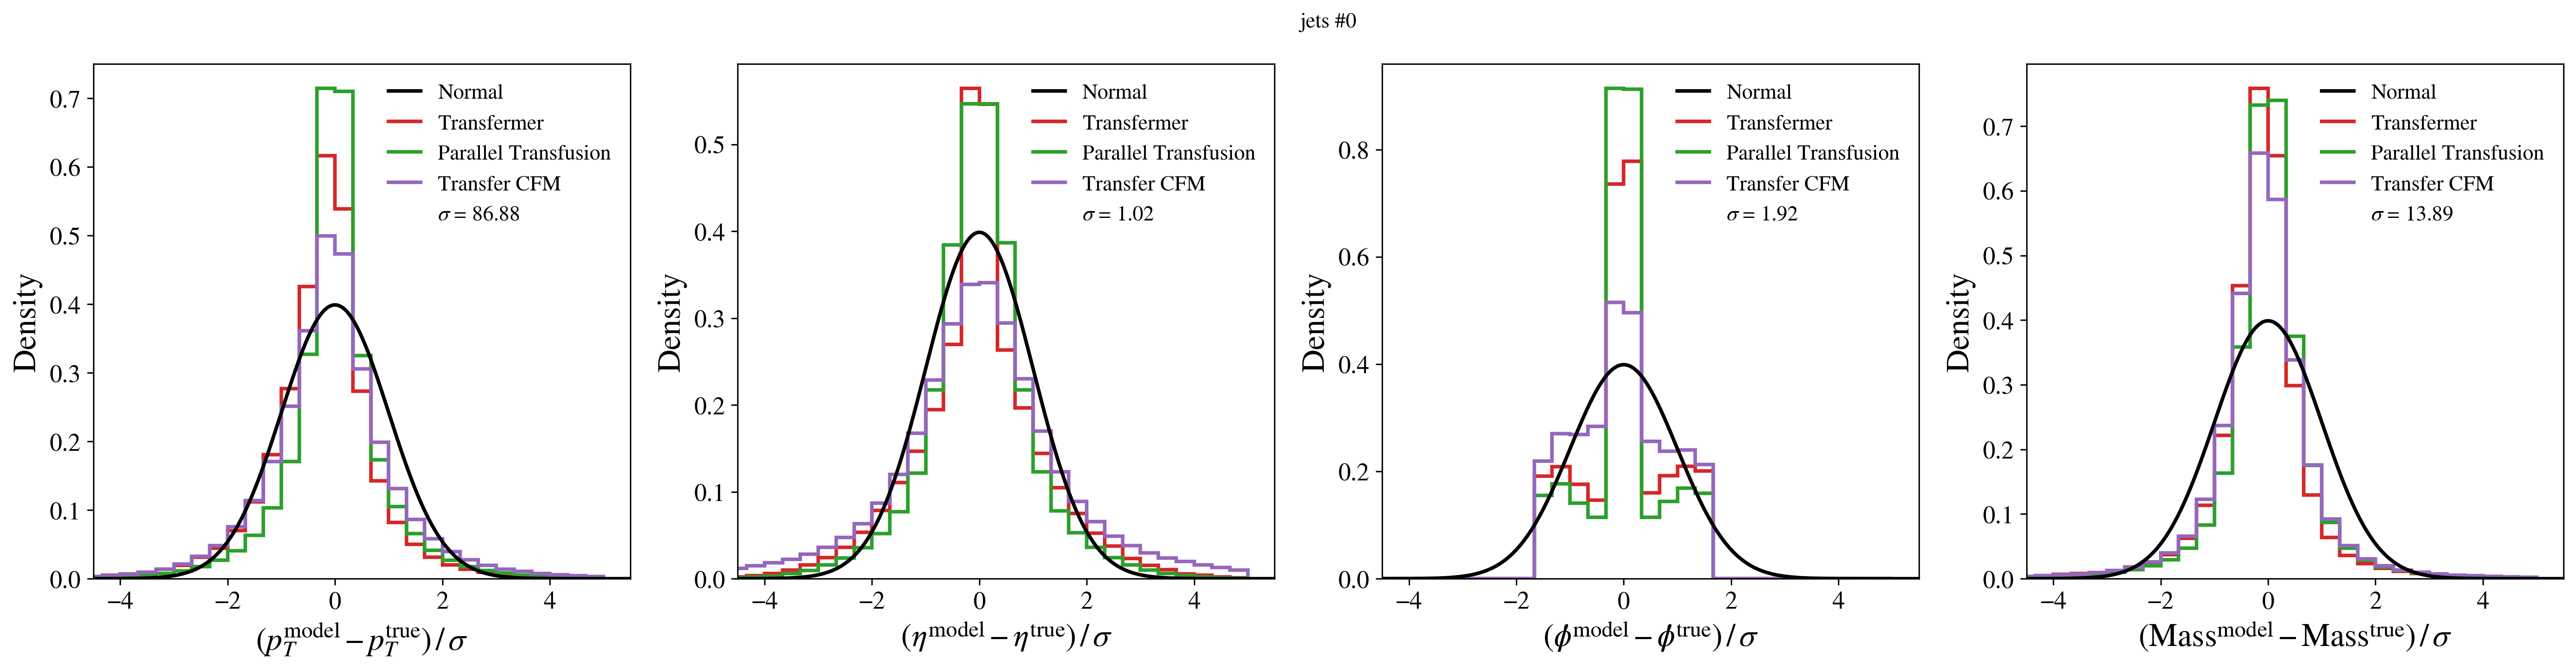

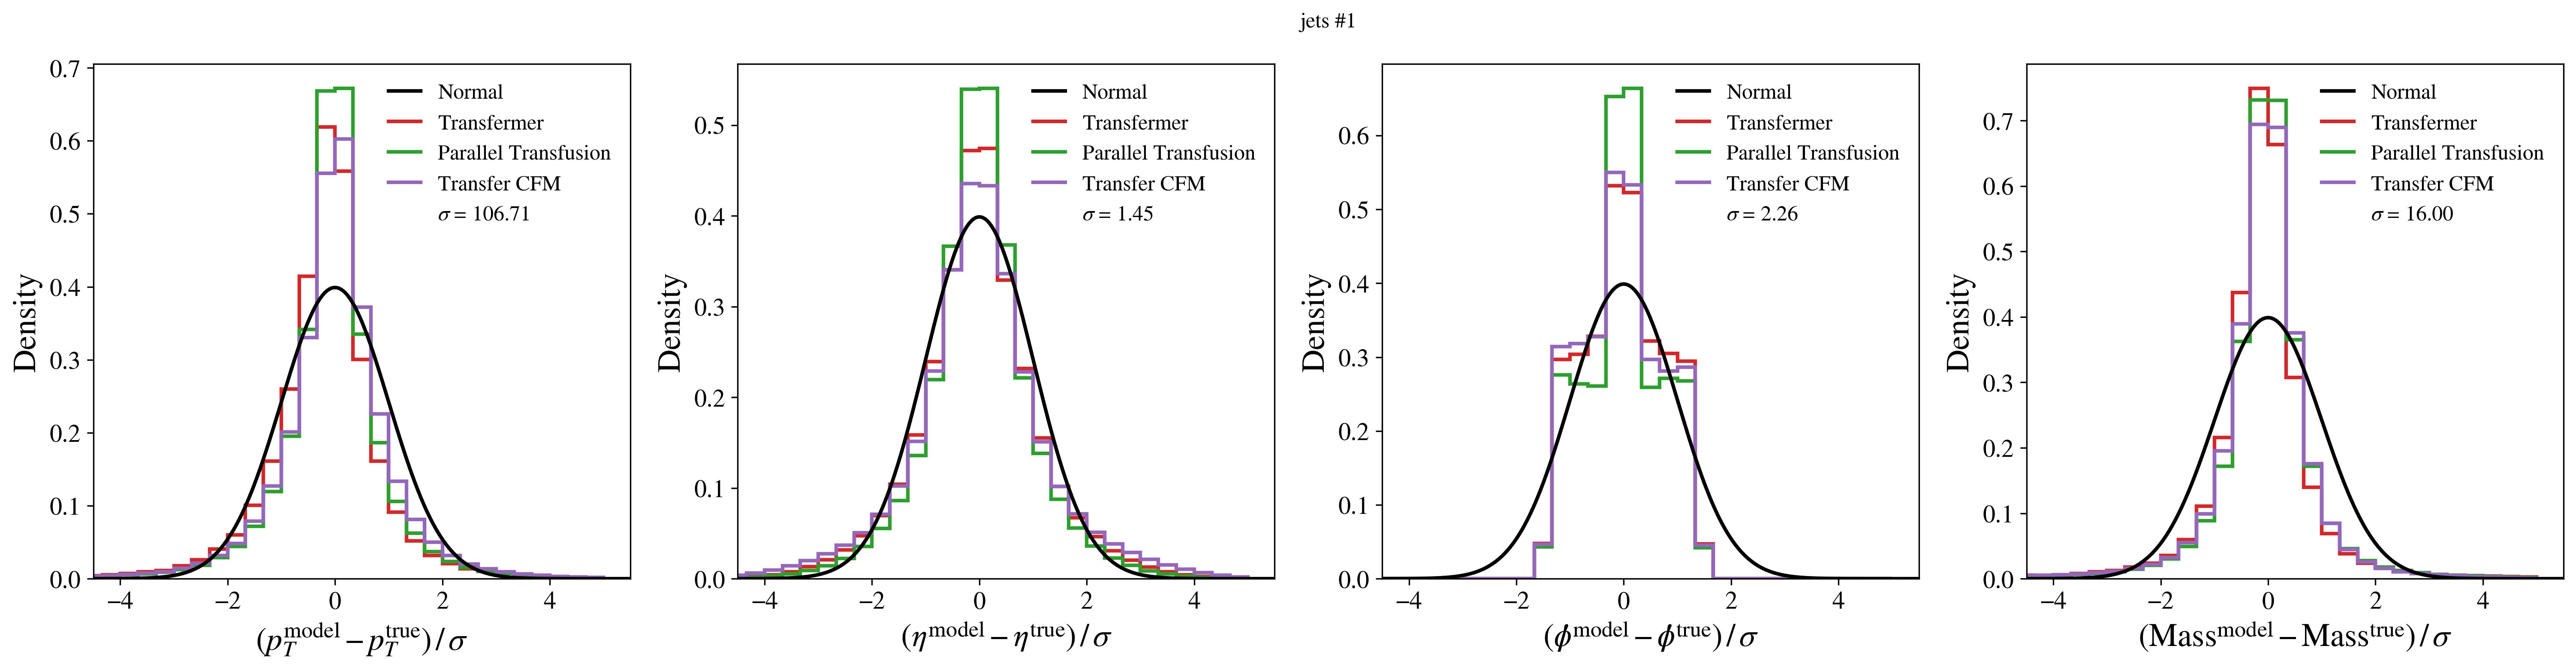

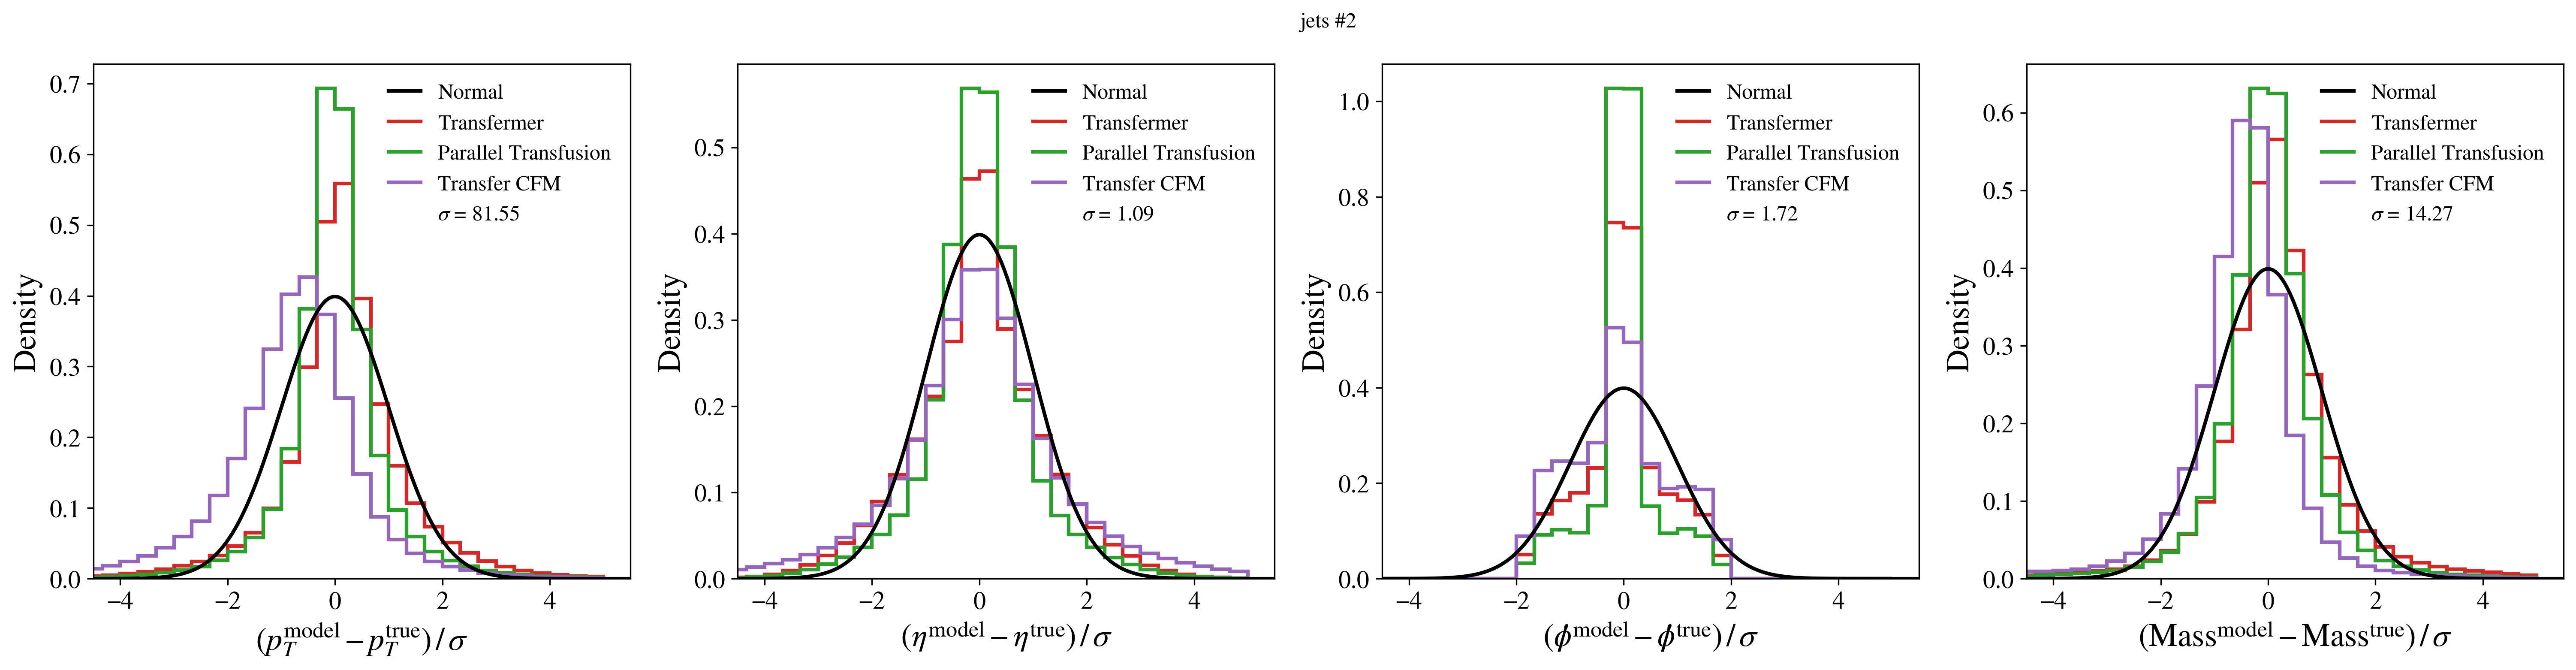

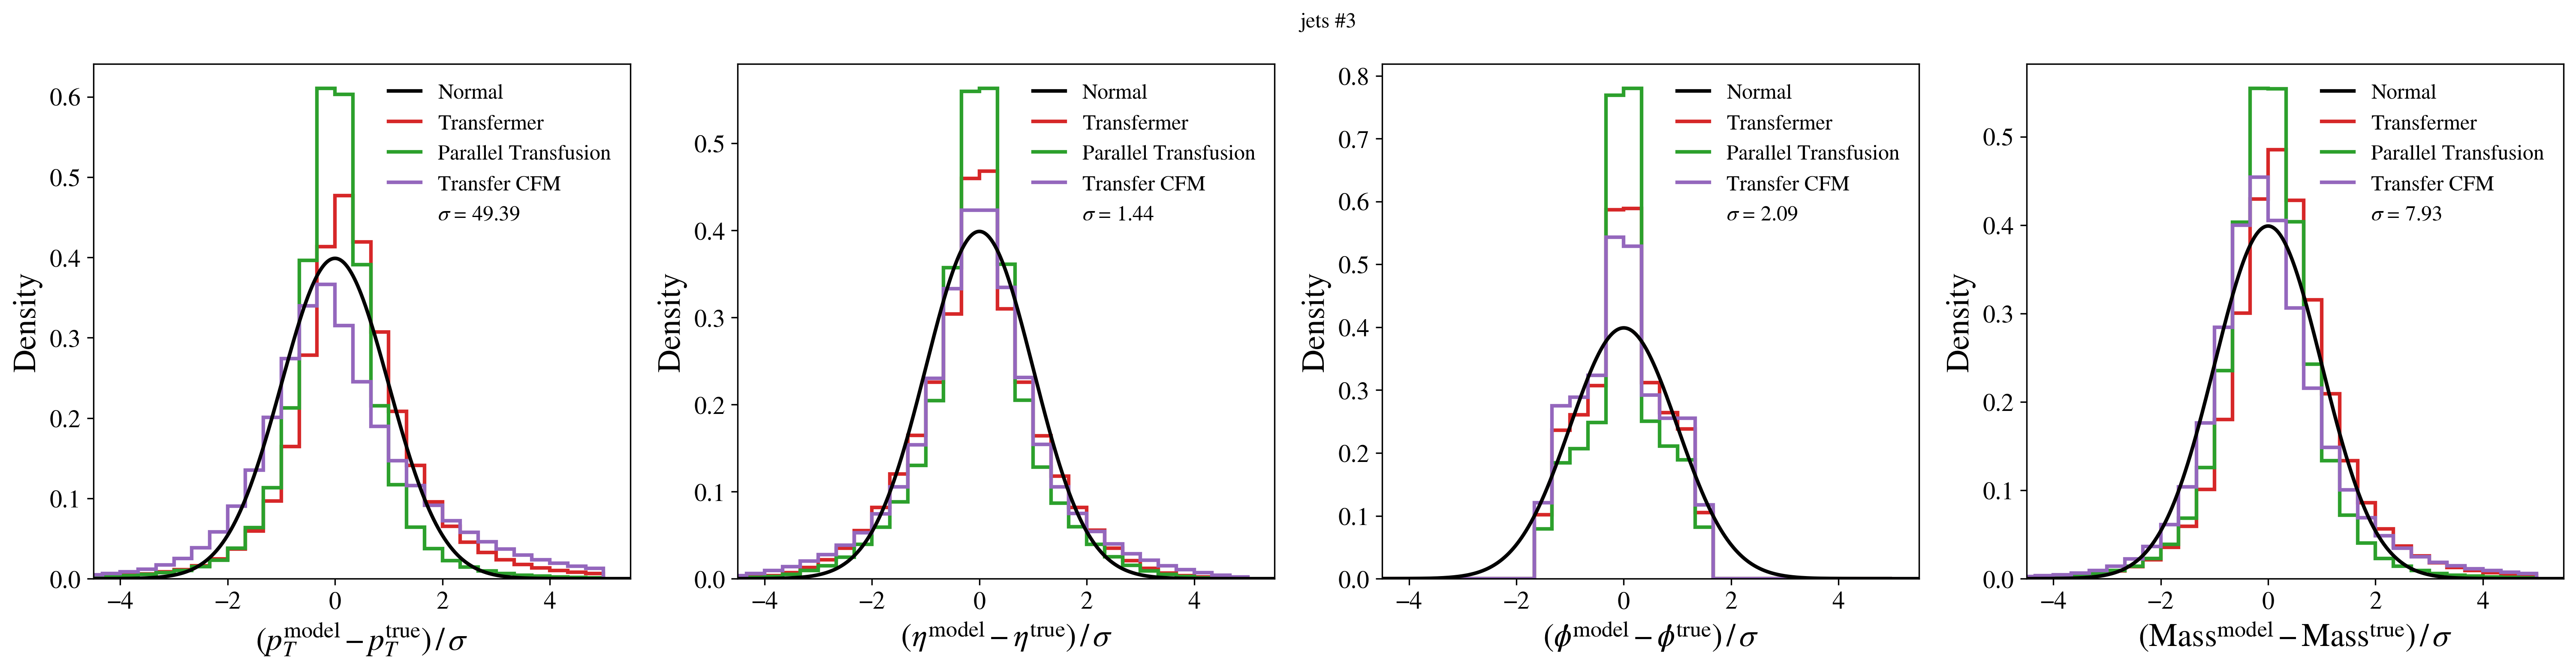

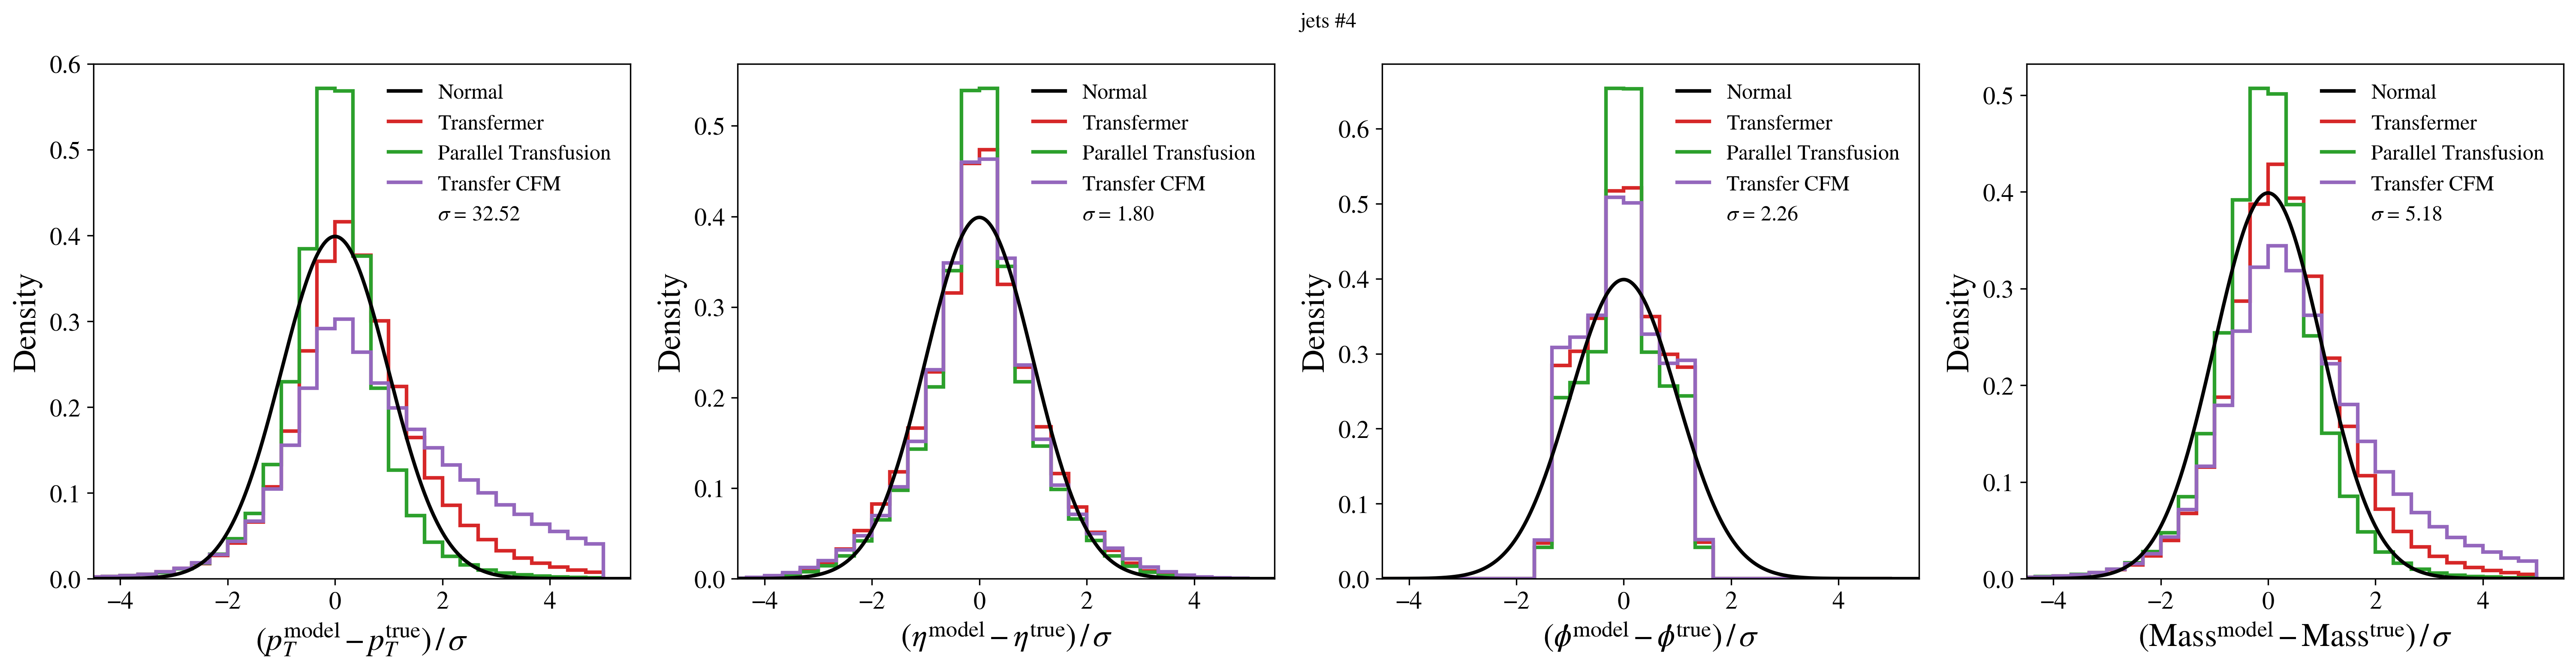

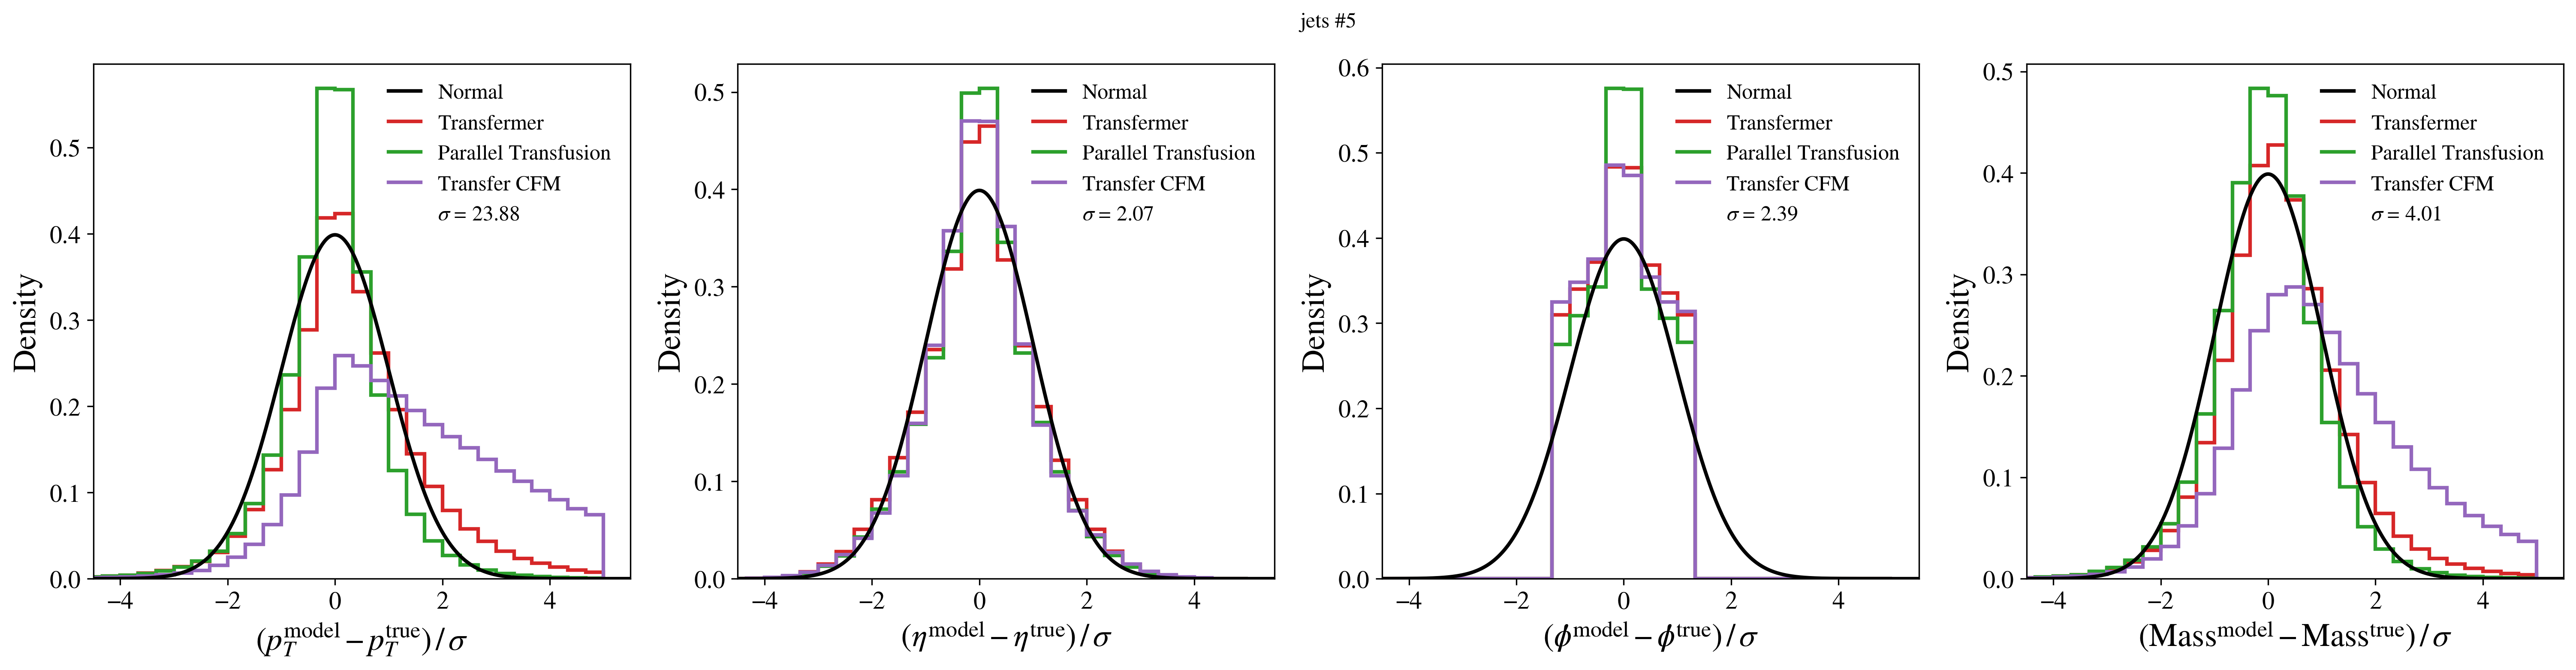

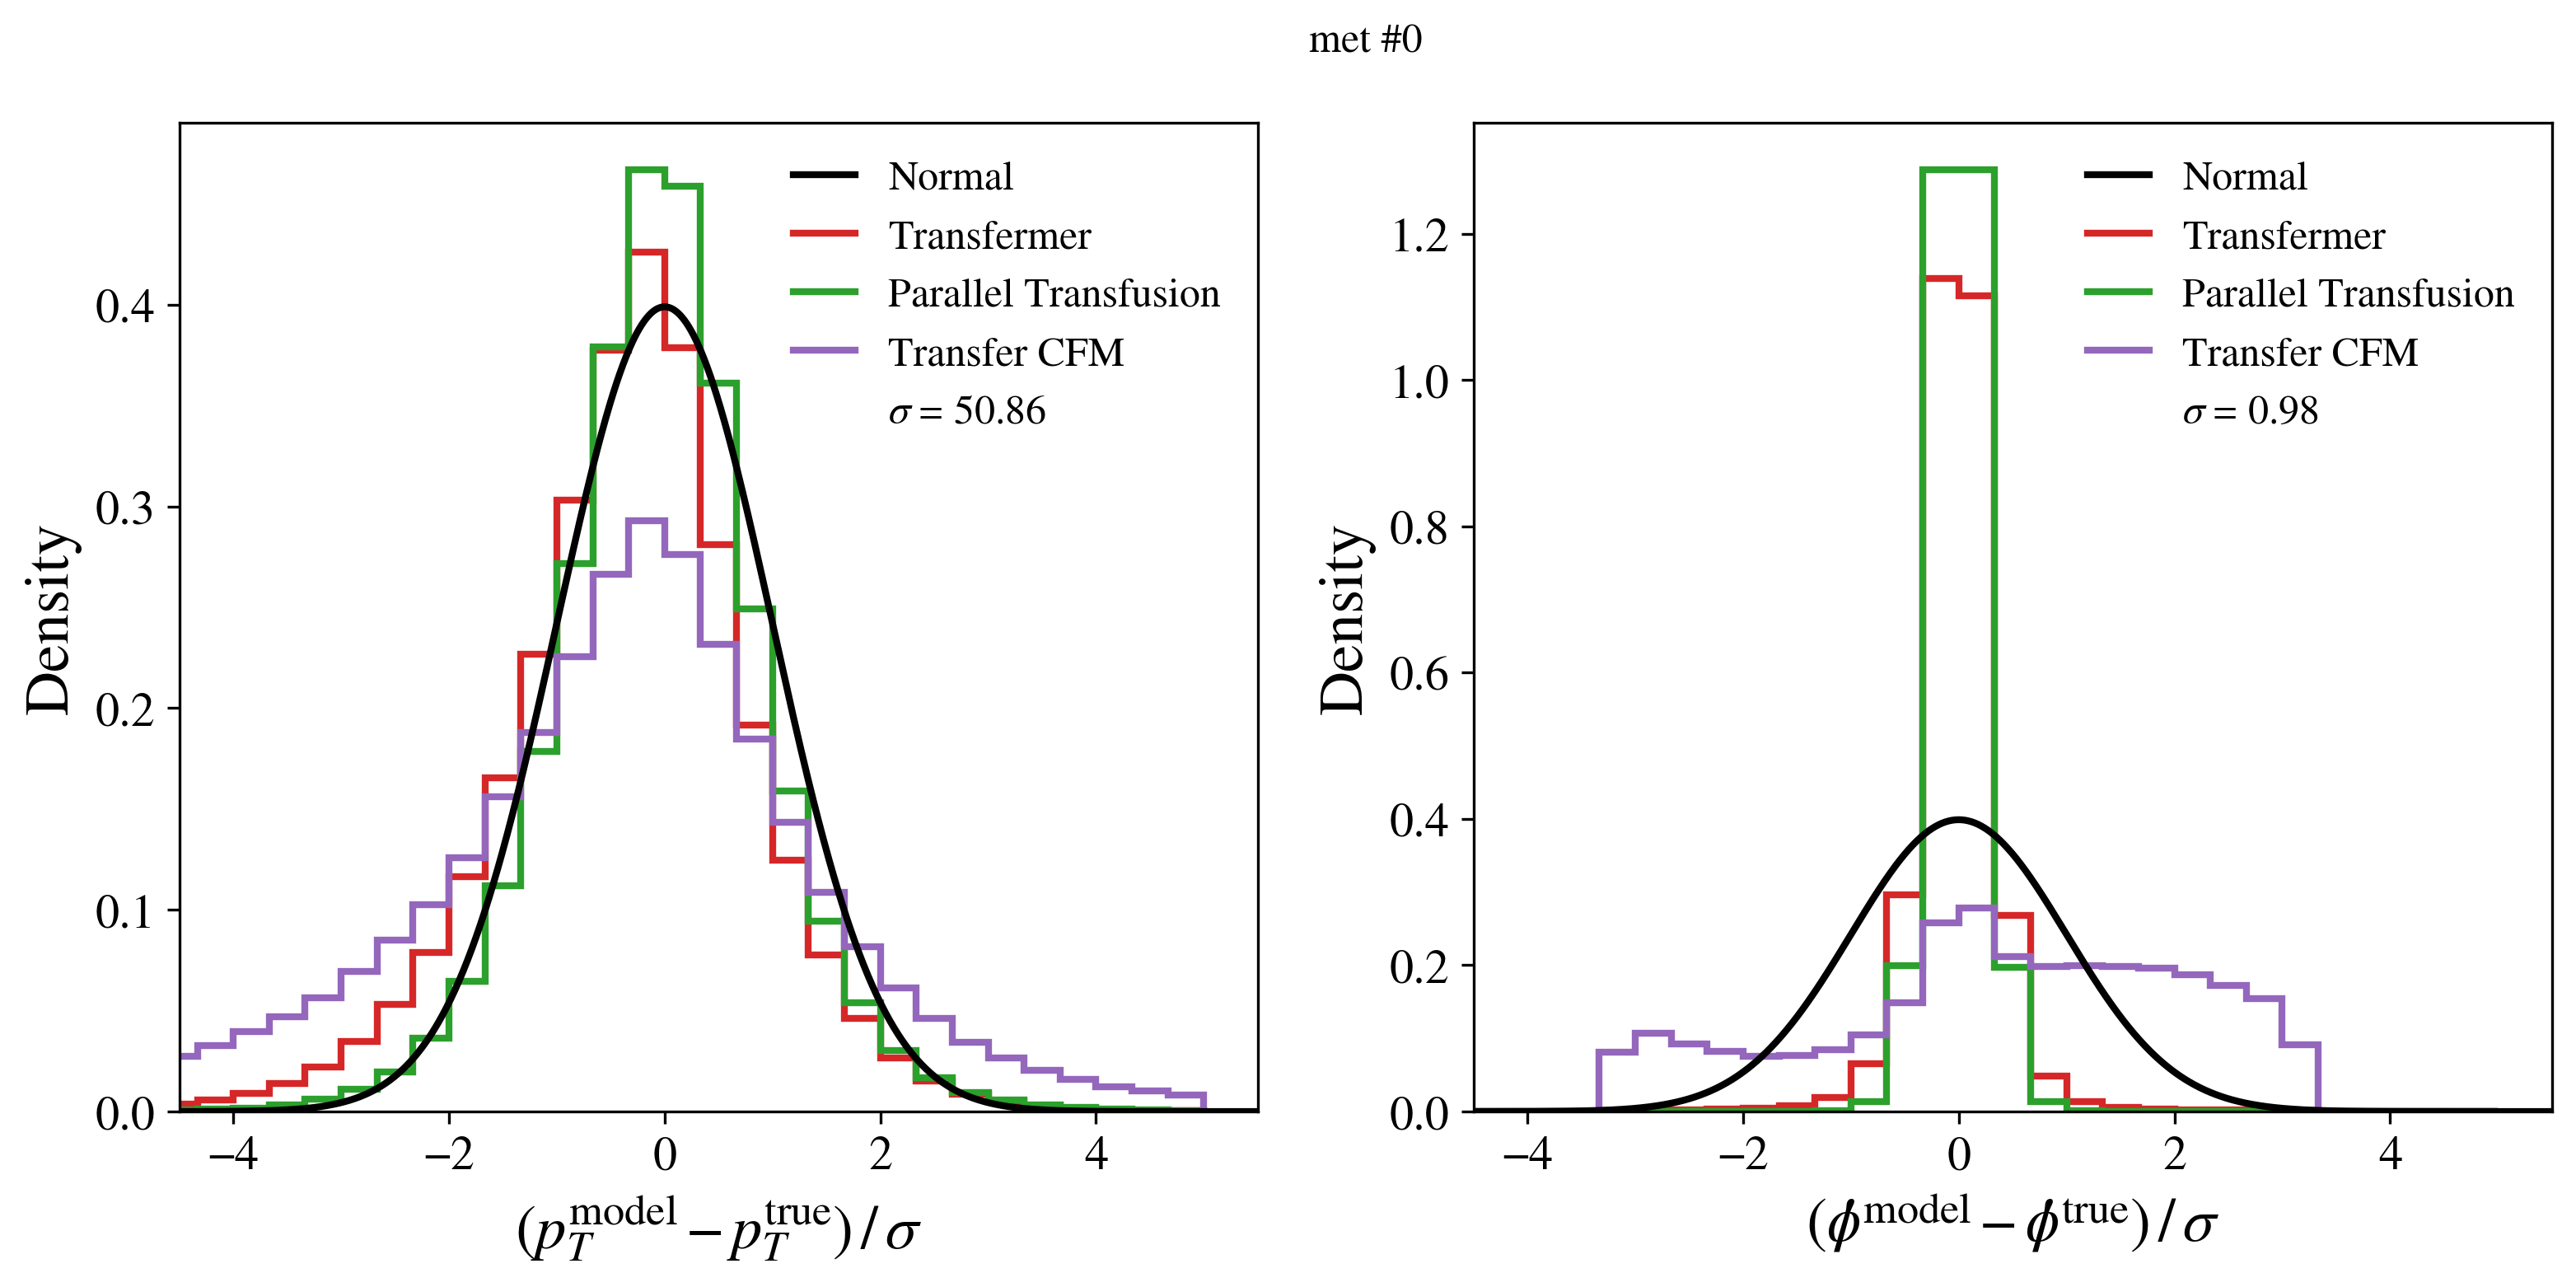

In [22]:
transfermer_bias_samples = load_samples(transfermer_bias_samples_file)
PT_bias_samples = load_samples(PT_bias_samples_file)
TransferCFM_bias_samples = load_samples(TransferCFM_bias_samples_file)

external_samples = [ # Make sure order is: [Transfermer, PT, TransferCFM]
    transfermer_bias_samples,
    PT_bias_samples,
    TransferCFM_bias_samples
]
figs = multi_histograms.make_error_plots(ParallelTransfusion_model,show=True,external_samples=external_samples,normalize_global=True)